### Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine.
Select the option that's closest to your solution.

### Dataset

In this homework, we will use the California Housing Prices data from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```
We'll keep working with the `'median_house_value'` variable, and we'll transform it to a classification task.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")


### Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`,

In [2]:
usecolumns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population",
              "households",
              "median_income", "median_house_value", "ocean_proximity"]

df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv", usecols=usecolumns)

In [3]:
df.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


In [4]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


### Data preparation

* Select only the features from above and fill in the missing values with median.
* Create a new column `rooms_per_household` by dividing the column `total_rooms` by the column `households` from dataframe.
* Create a new column `bedrooms_per_room` by dividing the column `total_bedrooms` by the column `total_rooms` from dataframe.
* Create a new column `population_per_household` by dividing the column `population` by the column `households` from dataframe.


In [5]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
t_b_median = df.total_bedrooms.median()
df.total_bedrooms = df.total_bedrooms.fillna(t_b_median)

In [7]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']


### Question 1

What is the most frequent observation (mode) for the column `ocean_proximity`?

Options:
* `NEAR BAY`
* `<1H OCEAN`
* `INLAND`
* `NEAR OCEAN`


In [8]:
df.ocean_proximity.mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object


### Question 2

* Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your train dataset.
    - In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
* What are the two features that have the biggest correlation in this dataset?

Options:
* `total_bedrooms` and `households`
* `total_bedrooms` and `total_rooms`
* `population` and `households`
* `population_per_household` and `total_rooms`


In [9]:
num_col = df.select_dtypes('float64').columns
num_col

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household', 'bedrooms_per_room',
       'population_per_household'],
      dtype='object')

<AxesSubplot:>

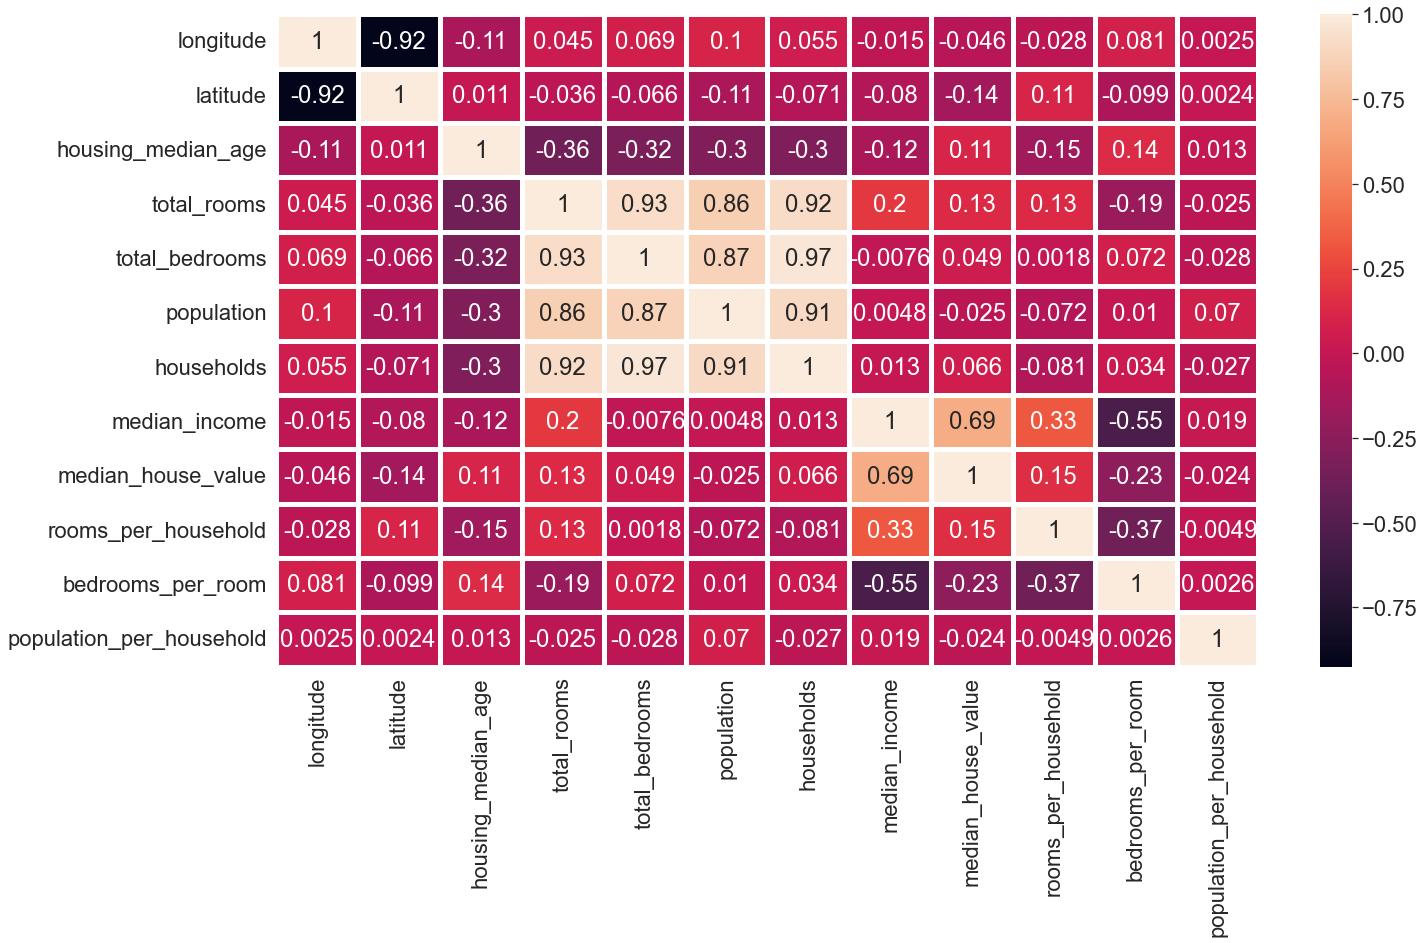

In [10]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(df[num_col].corr(), annot=True, linewidths=5, ax=ax)

In [11]:
df.total_bedrooms.corr(df.households) # its the biggest

0.9743662937706989

In [15]:
df.total_bedrooms.corr(df.total_rooms)

0.9270581965414186

In [13]:
df.population.corr(df.households)

0.9072222660959619

In [14]:
df.population_per_household.corr(df.total_rooms)

-0.024580658993988022


### Make `median_house_value` binary

* We need to turn the `median_house_value` variable from numeric into binary.
* Let's create a variable `above_average` which is `1` if the `median_house_value` is above its mean value and `0` otherwise.

In [19]:
avg_mvm = df.median_house_value.mean()
avg_mvm

206855.81690891474

In [21]:
df['above_average'] = df.median_house_value.apply(lambda x: 1 if x > avg_mvm else 0)

In [22]:
df['above_average'].value_counts()

0    12255
1     8385
Name: above_average, dtype: int64


### Split the data

* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to 42.
* Make sure that the target value (`median_house_value`) is not in your dataframe.

In [39]:
data = df.copy()
data = data.drop('median_house_value', axis=1)

In [40]:
seed = 42
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

In [41]:
df_train.shape, df_test.shape, df_val.shape

((12384, 13), (4128, 13), (4128, 13))

In [42]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [43]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values


### Question 3

* Calculate the *mutual information score* between `above_average` and `ocean_proximity` . Use the training set only.
* Round it to 2 decimals using `round(score, 2)`
* What is their *mutual information score*?


Options:
- 0.26
- 0
- 0.10
- 0.16


In [48]:
round(mutual_info_score(df_train.above_average, df_train.ocean_proximity), 1)

0.1

In [49]:
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']


### Question 4

* Now let's train a logistic regression
* Remember that we have one categorical variable `ocean_proximity` in the data. Include it using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

Options:
- 0.60
- 0.72
- 0.84
- 0.95


In [51]:
df_train.ocean_proximity.value_counts()

<1H OCEAN     5472
INLAND        3955
NEAR OCEAN    1558
NEAR BAY      1397
ISLAND           2
Name: ocean_proximity, dtype: int64

In [54]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

In [58]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [60]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
round(accuracy, 2)

0.84


### Question 5

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
* Which of following feature has the smallest difference?
   * `total_rooms`
   * `total_bedrooms`
   * `population`
   * `households`

> **Note**: the difference doesn't have to be positive


In [101]:
def prepare(set_col):
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[set_col].to_dict(orient='records')
    val_dict = df_val[set_col].to_dict(orient='records')
    test_dict = df_test[set_col].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)
    X_test = dv.transform(test_dict)
    return X_train, X_val, X_test

In [112]:
orig_acc = accuracy
col = list(df_train.columns)
list_diff_score = []
for c in col:
    set_col = col.copy()
    set_col.remove(c)
    X_train, X_val, X_test = prepare(set_col=set_col)
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = round(accuracy_score(y_val, y_pred), 4)
    list_diff_score.append({'c': c, 'orig_acc': orig_acc, 'acc_with_f': acc, 'diff_score': orig_acc - acc})

In [113]:
data_score = pd.DataFrame(list_diff_score)
data_score[data_score.diff_score == data_score.diff_score.min()]

,c,orig_acc,acc_with_f,diff_score
4,total_bedrooms,0.835998,0.8372,-0.001202



### Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn
* We'll need to use the original column `'median_house_value'`. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model (`model = Ridge(alpha=a, solver="sag", random_state=42)`) on the training data.
* This model has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`
* Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

If there are multiple options, select the smallest `alpha`.

Options:
- 0
- 0.01
- 0.1
- 1
- 10



In [138]:
data_l = df.copy()
del data_l['above_average']
data_l['median_house_value'] = np.log1p(data_l['median_house_value'])

In [139]:
seed = 42
df_full_train, df_test = train_test_split(data_l, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

In [140]:
df_train.shape, df_test.shape, df_val.shape

((12384, 13), (4128, 13), (4128, 13))

In [141]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [142]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [143]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [144]:
dv = DictVectorizer(sparse=False)

In [145]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [149]:
alpha = [0, 0.01, 0.1, 1, 10]
score_dict = []
for a in alpha:
    model_l = model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    RMSE = round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)
    score_dict.append({'alpha': a, 'RMSE': RMSE})

In [150]:
data_score = pd.DataFrame(score_dict)

In [151]:
data_score

,alpha,RMSE
0,0.00,0.524
1,0.01,0.524
2,0.10,0.524
3,1.00,0.524
4,10.00,0.524



## Submit the results

* Submit your results here: https://forms.gle/vQXAnQDeqA81HSu86
* You can submit your solution multiple times. In this case, only the last submission will be used
* If your answer doesn't match options exactly, select the closest one
